In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from model import MangaColorizer
from utils import ImageDataset, adjust_output_shape

## Model architecture

In [3]:
model = MangaColorizer()
model

MangaColorizer(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

## Loading the Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ImageDataset(dir="/kaggle/input/manga-panels-colored/data/train", 
                             transform=transform)
validation_dataset = ImageDataset(dir="/kaggle/input/manga-panels-colored/data/validation", 
                                  transform=transform)
test_dataset = ImageDataset(dir="/kaggle/input/manga-panels-colored/data/test", 
                            transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

## Training the model

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
num_epochs = 100
num_training_steps = num_epochs * len(train_loader)
progress_bar = tqdm(range(num_training_steps))

train_losses = []
valid_losses = []

best_valid_loss = float("inf")
epochs_no_improve = 0
patience = 10
best_model = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        try:
            loss = criterion(outputs, targets)
        except RuntimeError:
            adjusted_output = adjust_output_shape(outputs, targets)
            loss = criterion(adjusted_output, targets)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            try:
                loss = criterion(outputs, targets)
            except RuntimeError:
                adjusted_output = adjust_output_shape(outputs, targets)
                loss = criterion(adjusted_output, targets)
            valid_loss += loss.item()
        
        valid_loss /= len(validation_loader)
        valid_losses.append(valid_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_loss:.4f}') 
    torch.save(model.state_dict(), "last_checkpoint.pth")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        best_model = model.state_dict()
        torch.save(best_model, "best_model_checkpoint.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs with no improvement.")
            break

model.load_state_dict(best_model)

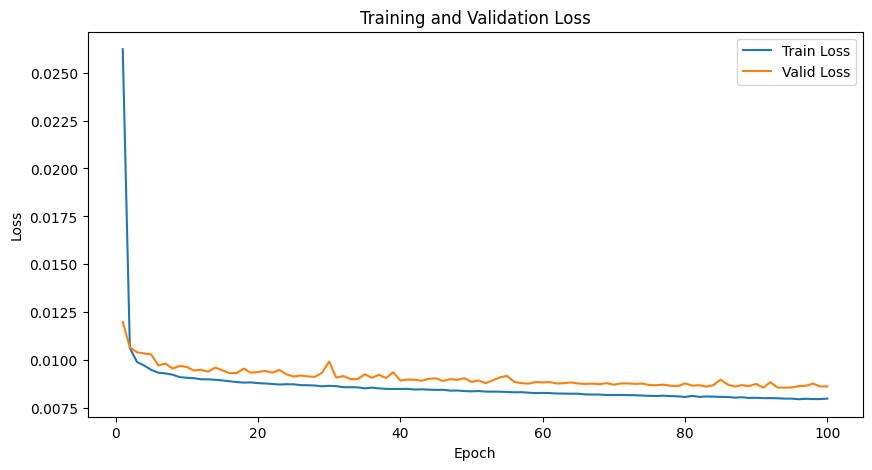

In [11]:
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        try:
            loss = criterion(outputs, targets)
        except RuntimeError:
            adjusted_output = adjust_output_shape(outputs, targets)
            loss = criterion(adjusted_output, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
print(f"The loss on the test set is {test_loss}")

The loss on the test set is 0.008598181701702099
